## Model Evaluating, Part 2

- Diagnosing bias and variance problems with learning curves 
- Grid search, nested cross-validation

#### Import and transform and divide the dataset

In [23]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder

# Assign features to NumPy array X
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

# Transform class labels into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Divide the dataset
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Verify the transformation of class variables
le.transform(['M', 'B'])

array([1, 0])

#### Learning curve function from scikit-learn

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([ ('scl', StandardScaler()),
                     ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Our model performs quite well on the dataset -- however, could be slightly overfitting indicated by a relatively small gap between training and cross-validation accuracy curves.

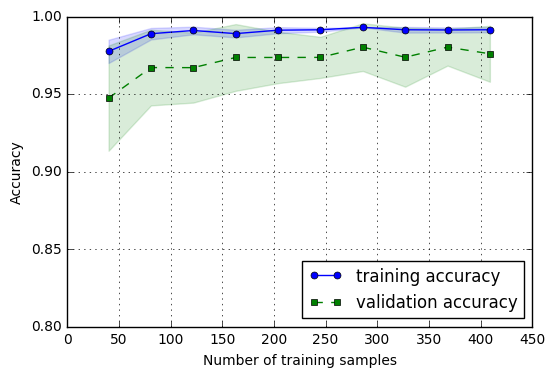

In [14]:
# Add plot of training accuracy
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
# Add standard deviation
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

# Add plot of validation accuracy
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
# Add standard deviation
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

#### Validation curves

In [39]:
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train, y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

validation_curve uses stratified k-fold cross-validation by default to estimate the performance of the model for classification. 

- (C = inverse regularization paramter of the LogisticRegression classifier, clf__C)
- We can see that the model slightly underfits the data when we increase the regularization strength (Small value of C). For larger values of C, we slighty overfit. In this case, the sweet spot is around **C=0.01**

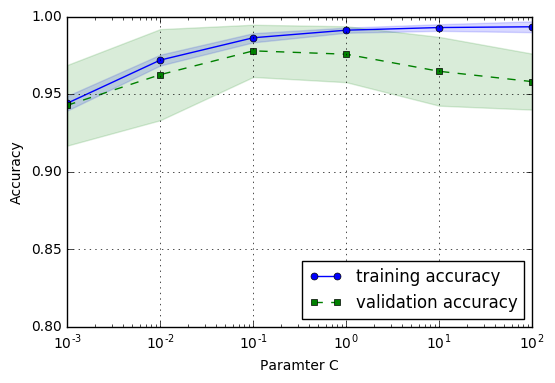

In [42]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Paramter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

---
### Fine-tuning with Grid Search

- Grid search - improve the performance of our model by finding the optimal combination of hyperparameter values.
- Brute-force exhaustive search paradigm where we specify a list of values for different hyperparameters

In [53]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# A list of dictionaries to specify the parameters we want to tune.
param_grid = [{'clf__C': param_range,
                'clf__kernel': ['linear']},
               {'clf__C': param_range,
                'clf__gamma': param_range,
                'clf__kernel': ['rbf']}]

# Initialize GridSearchSV object to train and tune a SVM pipeline
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

# Fit the data
gs = gs.fit(X_train, y_train)

In this example, **clf__C = 0.1** yields the best k-fold cross-validation accuracy at **97.8%**

In [54]:
# The score of the best-performing model
print(gs.best_score_)

0.978021978021978


In [55]:
# Parameters for the best score
print(gs.best_params_)

{'clf__kernel': 'linear', 'clf__C': 0.1}


Use the independent test dataset to estimate the performance 

In [58]:
clf = gs.best_estimator_

clf.fit(X_train, y_train)

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


### Algorithm selection with nested cross-validation

In [63]:
from sklearn.cross_validation import cross_val_score

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025
